#  FedAvg on cifar10
FedAvg implementation that trains a model using 3 clients, 10 communication rounds, 2 local epochs.

## Importing Libraries and Data

In [9]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

## Define The CNN

In [10]:
class CifarNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.bn5(self.fc1(x))))
        x = self.dropout(F.relu(self.bn6(self.fc2(x))))
        x = self.fc3(x)
        return x

## Define Client Class
A class to represent a single client, providing data generation, model training and model recieving/setting functionality. In a true FedAvg implementation the functionality of this class would operate on a seperate device and communicate via a network.

In [11]:
class Client():
    def __init__(self, name, server):
        self.name = name
        self.server = server
        self.client_losses = []
        self.client_accuracies = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Client {self.name} created on {self.server.name}")

    def set_dataset(self, dataset):
        self.cifar10_trainloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.server.batch_size,
            shuffle=True,
            num_workers=2
        )
        
        print(f"Added {len(dataset)} cifar10 datapoints to client {self.name} of {self.server.name}")

    def set_model(self, model):
        self.local_model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.local_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

    def train(self):
        total_loss = 0
        total_batches = 0

        self.local_model.train()
        for epoch in range(self.server.local_epochs):
            for batch_idx, (data, targets) in enumerate(self.cifar10_trainloader):
                data = data.to(self.server.device)
                targets = targets.to(self.server.device)
                scores = self.local_model(data)
                loss = self.criterion(scores, targets)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                total_batches += 1
        average_loss = total_loss / total_batches
        self.client_losses.append(average_loss)
        local_accuracy = self.get_local_model_accuracy()
        self.client_accuracies.append(local_accuracy)
        print(f"Client {self.name} trained with average loss: {average_loss:.4f} and accuracy: {local_accuracy}")
    
    def get_local_model_accuracy(self):
        self.test_accuracy = self.server.calculate_accuracy(self.server.cifar10_testloader, self.local_model)
        return self.test_accuracy

## Define Server Class
Define a class to represent the centeral server, providing client and model management functionality.

In [12]:
class Server():
    def __init__(self, name, global_model = None):
        self.name = name
        self.clients = []
        self.global_model = global_model
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        self.cifar10_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
        self.batch_size = 128
        self.local_epochs = 3
        self.communication_rounds = 50
        self.global_accuracy = []
        self.average_accuracy = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def set_global_model(self, global_model):
        self.global_model = global_model

    def add_clients(self, client_amount):
        for i in range(client_amount):
            self.clients.append(Client(len(self.clients) + 1, self))

    def set_clients_model(self):
        for client in self.clients:
            client_model = CifarNN().to(self.device)
            client_model.load_state_dict(self.global_model.state_dict().copy())
            client.set_model(client_model)
        print(f"All {self.name} clients set to global model")
        print()

    def generate_clients_cifar10_data(self):
        '''
        Splits the cifar10 dataset equally among all clients
        '''
        dataset = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=self.transform)
        
        total_size = len(dataset)
        num_clients = len(self.clients)
        split_size = total_size // num_clients
        
        print(f"Dividing {total_size} samples among {num_clients} clients (~{split_size} samples each)")
        indices = torch.randperm(total_size)
        
        client_indices = []
        for i in range(num_clients):
            start_idx = i * split_size
            end_idx = (i + 1) * split_size if i < num_clients - 1 else total_size
            client_indices.append(indices[start_idx:end_idx])
        
        for i, client in enumerate(self.clients):
            client_dataset = torch.utils.data.Subset(dataset, client_indices[i])
            client.set_dataset(client_dataset)

    def train_clients_round(self):
        for client in self.clients:
            client.train()

    def build_converged_model(self):
        """
        Create a new global model by averaging all client models' parameters
        """
    
        first_client_dict = self.clients[0].local_model.state_dict()

        averaged_state_dict = {}
        for parameter_name in first_client_dict.keys():
            client_parameters = []
            for client in self.clients:
                client_state_dict = client.local_model.state_dict()
                param_tensor = client_state_dict[parameter_name].float()
                client_parameters.append(param_tensor)
            
            stacked_parameters = torch.stack(client_parameters, dim=0)
            averaged_parameters = torch.mean(stacked_parameters, dim=0)
            
            original_dtype = first_client_dict[parameter_name].dtype
            averaged_state_dict[parameter_name] = averaged_parameters.to(original_dtype)
        
        converged_model = CifarNN().to(self.device)
        converged_model.load_state_dict(averaged_state_dict)
        
        print(f"Successfully converged models from {len(self.clients)} clients")
        return converged_model

    def converge_client_models(self):
        new_global_model = self.build_converged_model()
        self.set_global_model(new_global_model)            

    def fed_avg(self, communication_rounds):
        self.communication_rounds = communication_rounds
        print(f"Training {len(self.clients)} clients on {self.name} with hyperparameters of {self.batch_size} batch size, {self.local_epochs} local epochs and {self.communication_rounds} communication rounds")
        for round in range(self.communication_rounds):
            self.set_clients_model()
            self.train_clients_round()
            average_model_accuracy = self.test_client_models()
            self.average_accuracy.append(average_model_accuracy)

            self.converge_client_models()
            global_model_accuracy = self.calculate_accuracy(self.cifar10_testloader, self.global_model)
            self.global_accuracy.append(global_model_accuracy)

            print(f"Round {round + 1} complete:")
            print(f"Average client model accuracy (before convergence): {average_model_accuracy}")
            print(f"Global model accuracy (After convergence): {global_model_accuracy}")
        
        self.set_clients_model()
        print("Final round complete - all clients updated with converged model")

    def load_test_loader(self):
        self.cifar10_testset = datasets.CIFAR10(root='../data', train=False,
                                                        download=True, transform=self.transform)
        self.cifar10_testloader = torch.utils.data.DataLoader(self.cifar10_testset, batch_size=self.batch_size,
                                                            shuffle=False, num_workers=2)
        
    def calculate_accuracy(self, loader, model):
        number_correct = 0
        number_samples = 0
        model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                y = y.to(self.device)
                scores = model(x)
                _, predictions = scores.max(1)
                number_correct += (predictions == y).sum()
                number_samples += predictions.size(0)
        model.train()
        return number_correct / number_samples
        
    def test_client_models(self):
        '''
        Calculates the average accuracy of all the client models
        '''
        client_accuracy_average = 0
        for client in self.clients:
            client_accuracy = client.get_local_model_accuracy()
            client_accuracy_average += client_accuracy
        average_accuracy = client_accuracy_average / len(self.clients)
        return average_accuracy

## Load and Split Training Data
Use the class defined functions to initalise a server, add clients to the server and generate cifar10 data for each client.

In [13]:
cifar10_server = Server("cifar10_server")

cifar10_server.add_clients(5)

cifar10_server.generate_clients_cifar10_data()

Client 1 created on cifar10_server
Client 2 created on cifar10_server
Client 3 created on cifar10_server
Client 4 created on cifar10_server
Client 5 created on cifar10_server
Dividing 50000 samples among 5 clients (~10000 samples each)
Added 10000 cifar10 datapoints to client 1 of cifar10_server
Added 10000 cifar10 datapoints to client 2 of cifar10_server
Added 10000 cifar10 datapoints to client 3 of cifar10_server
Added 10000 cifar10 datapoints to client 4 of cifar10_server
Added 10000 cifar10 datapoints to client 5 of cifar10_server


## Initalise Server Model
Create an instance of the model and add it to the server

In [14]:
model =  CifarNN().to(cifar10_server.device)
print(f"Model: {model}")
cifar10_server.set_global_model(model)

Model: CifarNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn6): BatchNo

## Test Untrained Model
Load the test loader and test the untrained model to compare the accuracy later

In [15]:
cifar10_server.load_test_loader()
global_accuracy_untrained = cifar10_server.calculate_accuracy(cifar10_server.cifar10_testloader, cifar10_server.global_model)
print(f"Global model accuracy before training: {global_accuracy_untrained}")

Global model accuracy before training: 0.10209999978542328


## Run FedAvg Algorithm
Run the FedAvg algorithm for ten communication rounds

In [16]:
print(f"Training with device: {cifar10_server.device}")
cifar10_server.fed_avg(cifar10_server.communication_rounds)

Training with device: cuda
Training 5 clients on cifar10_server with hyperparameters of 128 batch size, 3 local epochs and 50 communication rounds
All cifar10_server clients set to global model

Client 1 trained with average loss: 1.8467 and accuracy: 0.43639999628067017
Client 2 trained with average loss: 1.8517 and accuracy: 0.4490000009536743
Client 3 trained with average loss: 1.8469 and accuracy: 0.44529998302459717
Client 4 trained with average loss: 1.8528 and accuracy: 0.4429999887943268
Client 5 trained with average loss: 1.8454 and accuracy: 0.45249998569488525
Successfully converged models from 5 clients
Round 1 complete:
Average client model accuracy (before convergence): 0.4435199797153473
Global model accuracy (After convergence): 0.4373999834060669
All cifar10_server clients set to global model

Client 1 trained with average loss: 1.5018 and accuracy: 0.5013999938964844
Client 2 trained with average loss: 1.5023 and accuracy: 0.5083000063896179
Client 3 trained with aver

## Test Global Model

In [17]:
global_accuracy_trained = cifar10_server.calculate_accuracy(cifar10_server.cifar10_testloader, cifar10_server.global_model)
print(f"Global Model Accuracy After Training: {global_accuracy_trained}")

Global Model Accuracy After Training: 0.8134999871253967


## Results

In [18]:
print(f"{cifar10_server.name} with {len(cifar10_server.clients)} clients FedAvg results:")
print(f"Global model accuracy before training: {global_accuracy_untrained}")
print(f"Global model accuracy after training: {global_accuracy_trained}")

cifar10_server with 5 clients FedAvg results:
Global model accuracy before training: 0.10209999978542328
Global model accuracy after training: 0.8134999871253967


## Convergence Analysis - Plot Average Client Accuracy and Global Model Accuracy
Compare the average client accuracy with the global model accuracy to derive convergence insights

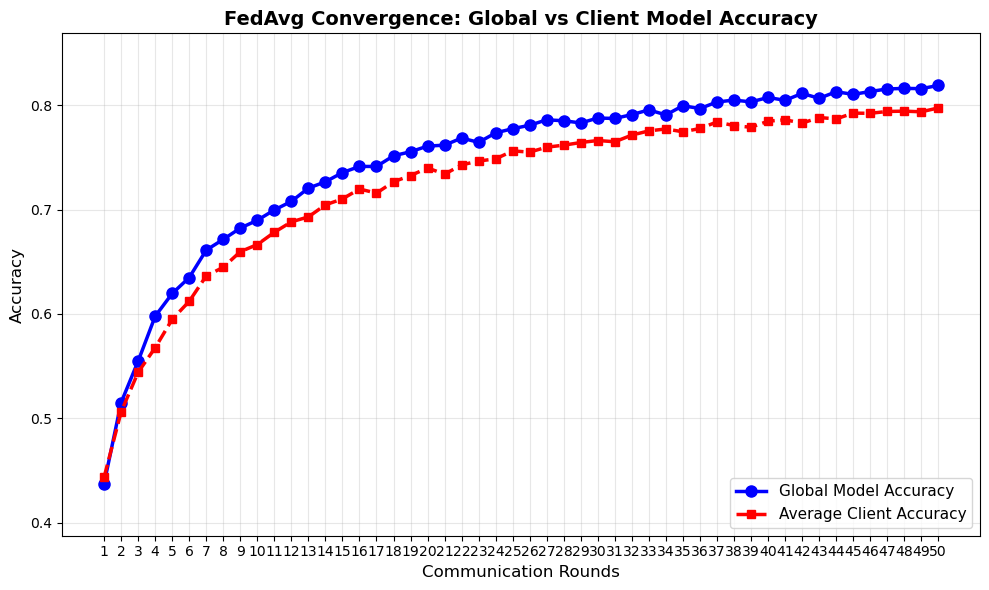

In [19]:
plt.figure(figsize=(10, 6))

# Check if we have data to plot
if len(cifar10_server.global_accuracy) == 0 or len(cifar10_server.average_accuracy) == 0:
    print("No accuracy data available. Please run the FedAvg training first.")
else:
    # Convert to regular Python floats
    global_accuracy_cpu = []
    for acc in cifar10_server.global_accuracy:
        if torch.is_tensor(acc):
            global_accuracy_cpu.append(acc.cpu().item())
        else:
            global_accuracy_cpu.append(float(acc))

    average_accuracy_cpu = []
    for acc in cifar10_server.average_accuracy:
        if torch.is_tensor(acc):
            average_accuracy_cpu.append(acc.cpu().item())
        else:
            average_accuracy_cpu.append(float(acc))

    rounds = range(1, len(global_accuracy_cpu) + 1)
    plt.plot(rounds, global_accuracy_cpu, 'b-', linewidth=2.5, marker='o', markersize=8, label='Global Model Accuracy')
    plt.plot(rounds, average_accuracy_cpu, 'r--', linewidth=2.5, marker='s', markersize=6, label='Average Client Accuracy')

    plt.xlabel('Communication Rounds', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('FedAvg Convergence: Global vs Client Model Accuracy', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.xticks(rounds)

    # Adjust y-axis limits based on actual data
    min_acc = min(min(global_accuracy_cpu), min(average_accuracy_cpu))
    max_acc = max(max(global_accuracy_cpu), max(average_accuracy_cpu))
    plt.ylim(max(0, min_acc - 0.05), min(1.0, max_acc + 0.05))
    
    plt.tight_layout()
    plt.show()

## Plot Client Loss During Training
Show the accuracy over rounds to track the model improvements

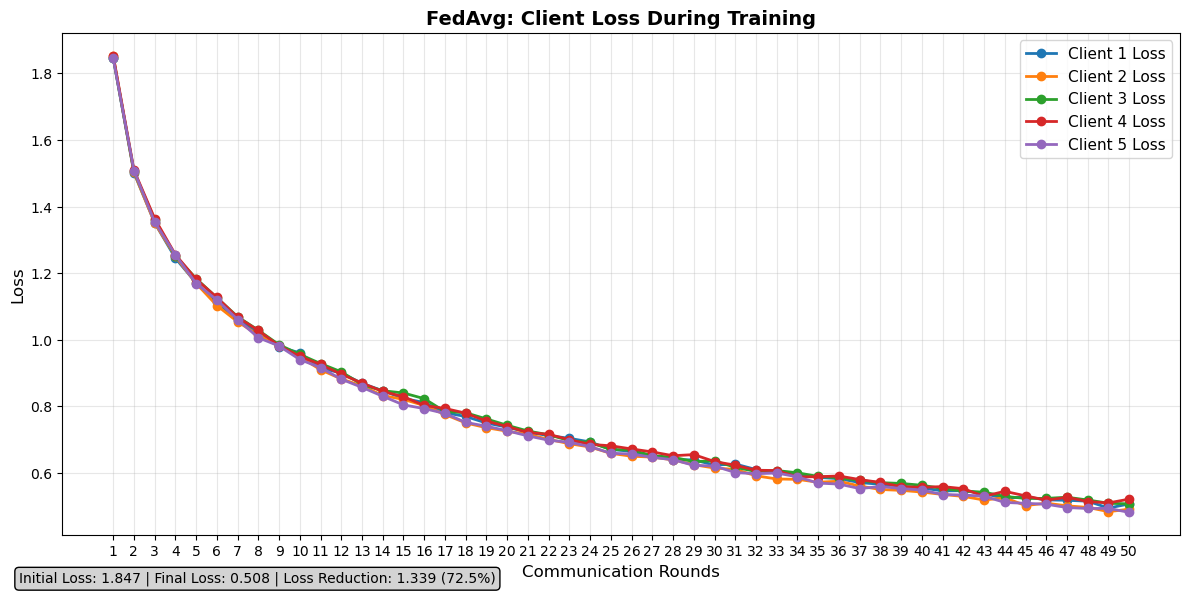

In [20]:
plt.figure(figsize=(12, 6))

rounds = range(1, len(cifar10_server.clients[0].client_losses) + 1)

for client in cifar10_server.clients:
    losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in client.client_losses]
    plt.plot(rounds, losses_cpu, linewidth=2, marker='o', 
             label=f'Client {client.name} Loss')

plt.xlabel('Communication Rounds', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('FedAvg: Client Loss During Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rounds)

initial_loss = cifar10_server.clients[0].client_losses[0]
final_loss = cifar10_server.clients[0].client_losses[-1]

if torch.is_tensor(initial_loss):
    initial_loss = initial_loss.cpu().item()
if torch.is_tensor(final_loss):
    final_loss = final_loss.cpu().item()

loss_reduction = initial_loss - final_loss

plt.figtext(0.02, 0.02, f'Initial Loss: {initial_loss:.3f} | '
                            f'Final Loss: {final_loss:.3f} | '
                            f'Loss Reduction: {loss_reduction:.3f} ({loss_reduction/initial_loss:.1%})', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.show()